# Well Apparent Accommodation

This notebook uses pyWellSFM to compute apparent accommodation from wells

In [8]:
# SPDX-License-Identifier: Apache-2.0
# SPDX-FileContributor: Martin Lemay
import os
import sys

package_path = os.path.dirname(os.getcwd())
package_path = os.path.join(package_path, "src")
if package_path not in sys.path:
    sys.path.append(package_path)

import matplotlib.pyplot as plt
import numpy as np
from pywellsfm import (
    AccommodationSpaceWellCalculator,
    Curve,
    FaciesCriteria,
    FaciesCriteriaType,
    SedimentaryFacies,
    UncertaintyCurve,
    Well,
)
from striplog import Interval, Legend, Striplog

# defines facies bathymetry
sandstoneBathy = (0.0, 20.0)
siltstoneBathy = (20.0, 50.0)
shaleBathy = (40.0, 100.0)

# create and register Facies list
sandstoneFac = SedimentaryFacies(
    "sandstone",
    {FaciesCriteria("Bathymetry",
                    sandstoneBathy[0],
                    sandstoneBathy[1],
                    FaciesCriteriaType.SEDIMENTOLOGICAL)
    },
)

siltstoneFac = SedimentaryFacies(
    "siltstone",
    {FaciesCriteria("Bathymetry",
                    siltstoneBathy[0],
                    siltstoneBathy[1],
                    FaciesCriteriaType.SEDIMENTOLOGICAL)
    },
)

shaleFac = SedimentaryFacies(
    "shale", {FaciesCriteria("Bathymetry",
                             shaleBathy[0],
                             shaleBathy[1],
                             FaciesCriteriaType.SEDIMENTOLOGICAL)
             }
)

faciesList: list[SedimentaryFacies] = [
    sandstoneFac,
    siltstoneFac,
    shaleFac,
]

# legend for litho log plot
leg_txt = """colour,comp lithology
gold,sandstone
brown,siltstone
gray,shale
"""
legend = Legend.from_csv(text=leg_txt)

print(f"Facies list was created and contains {len(faciesList)} facies.")

Facies list was created and contains 3 facies.


In [9]:
lithoLogBarbierTxt = """top,base,comp lithology
0.0,15.0,sandstone
15.0,30.0,siltstone
30.0,55.0,shale
"""

wellCoords = np.array((0.0, 0.0, 0.0))
depth: float = 100.0
well: Well = Well("Well0", wellCoords, depth)
lithoLogName = "lithology"
lithoLog = Striplog.from_csv(text=lithoLogBarbierTxt)
well.addLog(lithoLogName, lithoLog)
curveAbscissa = np.linspace(0, depth, 101)
curveOrdinate = np.sin(curveAbscissa)
# add continuous log
log = Curve("Depth", "GR", curveAbscissa, curveOrdinate)
well.addLog("GR", log)

c:\Users\MartinLemay\OneDrive - ELIIS\PERSO\python\SFM\pyWellSFM\.venv\Lib\site-packages\striplog\striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


c:\Users\MartinLemay\OneDrive - ELIIS\PERSO\python\SFM\pyWellSFM\.venv\Lib\site-packages\striplog\striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


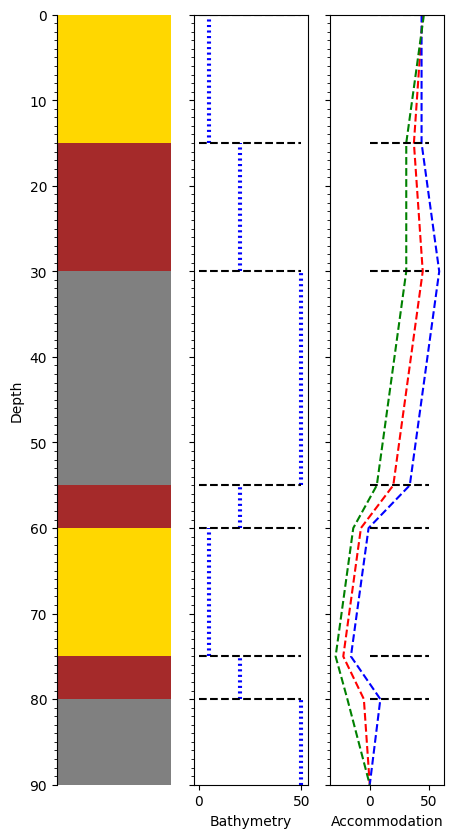

In [10]:
# Accommodation calculation tests
# case 1: Facies with restricted bathymetry range. 1 well with succession of
# facies. defines facies bathymetry
sandstoneBathyRestricted = (4.5, 5.5)
siltstoneBathyRestricted = (19.5, 20.5)
shaleBathyRestricted = (49.5, 50.5)

# create and register Facies list
sandstoneFac = SedimentaryFacies(
    "sandstone",
    {
        FaciesCriteria(
            "Bathymetry",
            sandstoneBathyRestricted[0],
            sandstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

siltstoneFac = SedimentaryFacies(
    "siltstone",
    {
        FaciesCriteria(
            "Bathymetry",
            siltstoneBathyRestricted[0],
            siltstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

shaleFac = SedimentaryFacies(
    "shale",
    {
        FaciesCriteria(
            "Bathymetry", shaleBathyRestricted[0], shaleBathyRestricted[1], FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

faciesListRestrictedBathy: list[SedimentaryFacies] = [
    sandstoneFac,
    siltstoneFac,
    shaleFac,
]

simpleLithoLog = """top,base,comp lithology
0.0,15.0,sandstone
15.0,30.0,siltstone
30.0,55.0,shale
55.0,60.0,siltstone
60.0,75.0,sandstone
75.0,80.0,siltstone
80.0,90.0,shale
"""

wellCoords = np.array((0.0, 0.0, 0.0))
depth: float = 100.0
well: Well = Well("Well0", wellCoords, depth)
lithoLogName = "lithology"
lithoLog = Striplog.from_csv(text=simpleLithoLog)
well.addLog(lithoLogName, lithoLog)

aspc = AccommodationSpaceWellCalculator(well, faciesListRestrictedBathy)
accoCurve: UncertaintyCurve = aspc.computeAccommodationCurve(lithoLogName)

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(5, 10), ncols=3, sharey=True)
lithoLog.plot(legend, ax=ax0)
ax0.set_ylabel("Depth")
for row in aspc._bathymetryStepCurve:
    ax1.plot((row[2], row[2]), row[:2], ":b")
    ax1.plot((row[3], row[3]), row[:2], ":b")
ax1.set_xlabel("Bathymetry")
ax2.plot(accoCurve.getMedianValues(), accoCurve.getAbscissa(), "--r")
ax2.plot(accoCurve.getMinValues(), accoCurve.getAbscissa(), "--b")
ax2.plot(accoCurve.getMaxValues(), accoCurve.getAbscissa(), "--g")
ax2.set_xlabel("Accommodation")

interval: Interval
for interval in lithoLog:
    ax1.hlines(interval.top.middle, 0, 50, colors="k", linestyles="--")
    ax2.hlines(interval.top.middle, 0, 50, colors="k", linestyles="--")
plt.show()

c:\Users\MartinLemay\OneDrive - ELIIS\PERSO\python\SFM\pyWellSFM\.venv\Lib\site-packages\striplog\striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


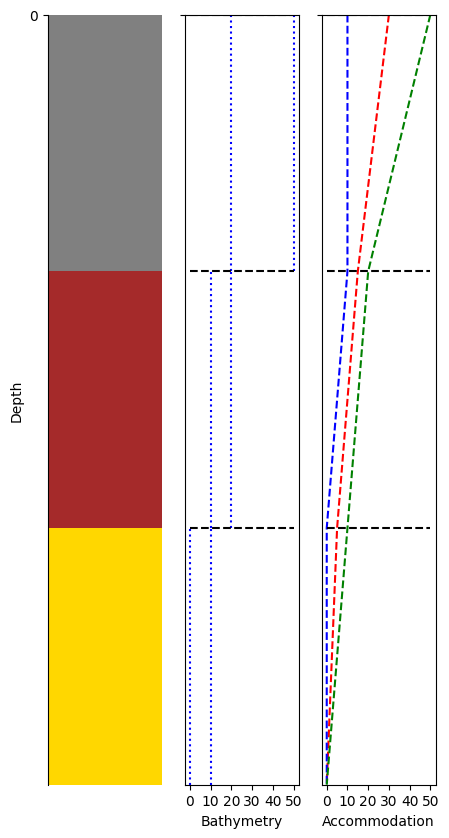

In [11]:
# Accommodation calculation tests
# case 1: Facies with restricted bathymetry range. 1 well with succession of
# facies. defines facies bathymetry
sandstoneBathyRestricted = (0, 10)
siltstoneBathyRestricted = (10, 20)
shaleBathyRestricted = (20, 50)

# create and register Facies list
sandstoneFac = SedimentaryFacies(
    "sandstone",
    {
        FaciesCriteria(
            "Bathymetry",
            sandstoneBathyRestricted[0],
            sandstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

siltstoneFac = SedimentaryFacies(
    "siltstone",
    {
        FaciesCriteria(
            "Bathymetry",
            siltstoneBathyRestricted[0],
            siltstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

shaleFac = SedimentaryFacies(
    "shale",
    {
        FaciesCriteria(
            "Bathymetry", shaleBathyRestricted[0], shaleBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

faciesList: list[SedimentaryFacies] = [
    sandstoneFac,
    siltstoneFac,
    shaleFac,
]

simpleLithoLog = """top,base,comp lithology
0.0,0.0001,shale
0.0001,0.0002,siltstone
0.0002,0.0003,sandstone
"""

wellCoords = np.array((0.0, 0.0, 0.0))
depth: float = 0.0005
well: Well = Well("Well0", wellCoords, depth)
lithoLogName = "lithology"
lithoLog = Striplog.from_csv(text=simpleLithoLog)
well.addLog(lithoLogName, lithoLog)

aspc = AccommodationSpaceWellCalculator(well, faciesList)
accoCurve: UncertaintyCurve = aspc.computeAccommodationCurve(lithoLogName)

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(5, 10), ncols=3, sharey=True)
lithoLog.plot(legend, ax=ax0)
ax0.set_ylabel("Depth")
for row in aspc._bathymetryStepCurve:
    ax1.plot((row[2], row[2]), row[:2], ":b")
    ax1.plot((row[3], row[3]), row[:2], ":b")
ax1.set_xlabel("Bathymetry")
ax2.plot(accoCurve.getMedianValues(), accoCurve.getAbscissa(), "--r")
ax2.plot(accoCurve.getMinValues(), accoCurve.getAbscissa(), "--b")
ax2.plot(accoCurve.getMaxValues(), accoCurve.getAbscissa(), "--g")
ax2.set_xlabel("Accommodation")

ax1.set_xticks(np.linspace(0, 50, 6))
ax2.set_xticks(np.linspace(-20, 50, 8))

interval: Interval
for interval in lithoLog:
    ax1.hlines(interval.top.middle, 0, 50, colors="k", linestyles="--")
    ax2.hlines(interval.top.middle, 0, 50, colors="k", linestyles="--")
plt.show()

c:\Users\MartinLemay\OneDrive - ELIIS\PERSO\python\SFM\pyWellSFM\.venv\Lib\site-packages\striplog\striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


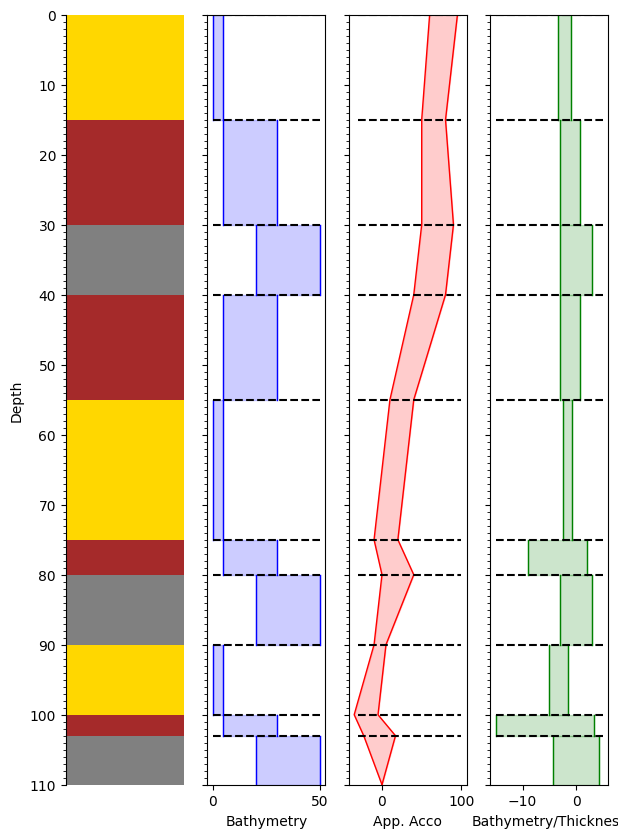

In [13]:
# Accommodation calculation tests
# case 1: Facies with restricted bathymetry range. 1 well with succession of
# facies. defines facies bathymetry
sandstoneBathyRestricted = (0, 5)
siltstoneBathyRestricted = (5, 30)
shaleBathyRestricted = (20, 50)

# create and register Facies list
sandstoneFac = SedimentaryFacies(
    "sandstone",
    {
        FaciesCriteria(
            "Bathymetry",
            sandstoneBathyRestricted[0],
            sandstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

siltstoneFac = SedimentaryFacies(
    "siltstone",
    {
        FaciesCriteria(
            "Bathymetry",
            siltstoneBathyRestricted[0],
            siltstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

shaleFac = SedimentaryFacies(
    "shale",
    {
        FaciesCriteria(
            "Bathymetry", shaleBathyRestricted[0], shaleBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

faciesListRestrictedBathy: list[SedimentaryFacies] = [
    sandstoneFac,
    siltstoneFac,
    shaleFac,
]

simpleLithoLog = """top,base,comp lithology
0.0,15.0,sandstone
15.0,30.0,siltstone
30.0,40.0,shale
40.0,55.0,siltstone
55.0,75.0,sandstone
75.0,80.0,siltstone
80.0,90.0,shale
90.0,100.0,sandstone
100.0,103.0,siltstone
103.0,110.0,shale
"""

wellCoords = np.array((0.0, 0.0, 0.0))
depth: float = 120.0
well: Well = Well("Well0", wellCoords, depth)
lithoLogName = "lithology"
lithoLog = Striplog.from_csv(text=simpleLithoLog)
well.addLog(lithoLogName, lithoLog)

aspc = AccommodationSpaceWellCalculator(well, faciesListRestrictedBathy)
accoCurve: UncertaintyCurve = aspc.computeAccommodationCurve(lithoLogName)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(7, 10), ncols=4, sharey=True)
lithoLog.plot(legend, ax=ax0)
ax0.set_ylabel("Depth")

bathy0 = aspc._bathymetryStepCurve[-1]
for i, row in enumerate(aspc._bathymetryStepCurve):
    ax1.plot((row[2], row[2]), row[:2], "-b", linewidth=1)
    ax1.plot((row[3], row[3]), row[:2], "-b", linewidth=1)
    ax1.fill_betweenx(
        row[:2], (row[2], row[2]), (row[3], row[3]), color="b", alpha=0.2
    )

    dbmin = row[2] - bathy0[3]
    dbmax = row[3] - bathy0[2]
    th = abs(lithoLog[i].top.middle - lithoLog[i].base.middle)
    btmin = dbmin / th
    btmax = dbmax / th
    ax3.plot((btmin, btmin), row[:2], "-g", linewidth=1)
    ax3.plot((btmax, btmax), row[:2], "-g", linewidth=1)
    ax3.fill_betweenx(
        row[:2], (btmin, btmin), (btmax, btmax), color="g", alpha=0.2
    )

ax1.set_xlabel("Bathymetry")
# ax2.plot(accoCurve.getMedianValues(), accoCurve.getAbscissa(), "--r")
ax2.plot(accoCurve.getMinValues(), accoCurve.getAbscissa(), "-r", linewidth=1)
ax2.plot(accoCurve.getMaxValues(), accoCurve.getAbscissa(), "-r", linewidth=1)
ax2.fill_betweenx(
    accoCurve.getAbscissa(),
    accoCurve.getMinValues(),
    accoCurve.getMaxValues(),
    color="r",
    alpha=0.2,
)
ax2.set_xlabel("App. Acco")

ax3.set_xlabel("Bathymetry/Thickness")
interval: Interval
for interval in lithoLog:
    ax1.hlines(interval.top.middle, 0, 50, colors="k", linestyles="--")
    ax2.hlines(interval.top.middle, -30, 100, colors="k", linestyles="--")
    ax3.hlines(interval.top.middle, -15, 5, colors="k", linestyles="--")
plt.show()

c:\Users\MartinLemay\OneDrive - ELIIS\PERSO\python\SFM\pyWellSFM\.venv\Lib\site-packages\striplog\striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


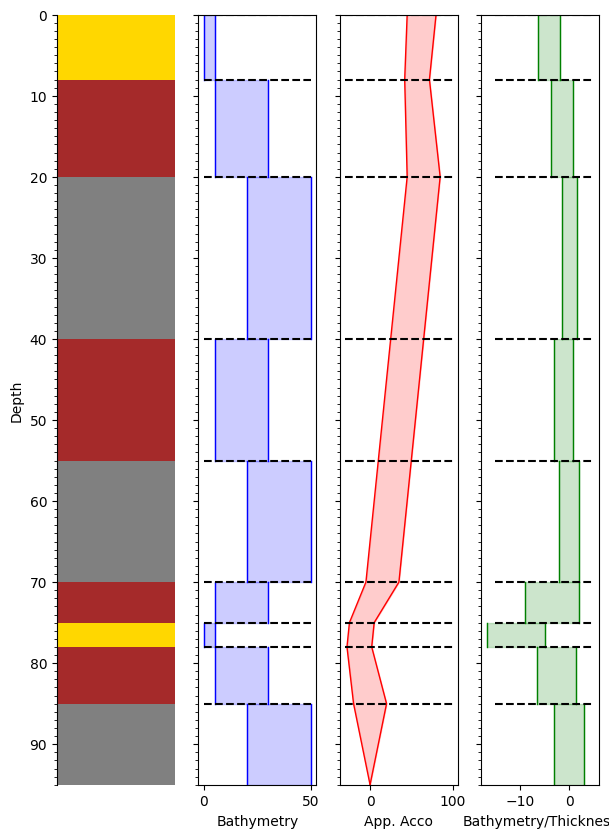

In [14]:
# Accommodation calculation tests
# case 1: Facies with restricted bathymetry range. 1 well with succession of
# facies. defines facies bathymetry
sandstoneBathyRestricted = (0, 5)
siltstoneBathyRestricted = (5, 30)
shaleBathyRestricted = (20, 50)

# create and register Facies list
sandstoneFac = SedimentaryFacies(
    "sandstone",
    {
        FaciesCriteria(
            "Bathymetry",
            sandstoneBathyRestricted[0],
            sandstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

siltstoneFac = SedimentaryFacies(
    "siltstone",
    {
        FaciesCriteria(
            "Bathymetry",
            siltstoneBathyRestricted[0],
            siltstoneBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

shaleFac = SedimentaryFacies(
    "shale",
    {
        FaciesCriteria(
            "Bathymetry", shaleBathyRestricted[0], shaleBathyRestricted[1],
            FaciesCriteriaType.SEDIMENTOLOGICAL,
        )
    },
)

faciesListRestrictedBathy: list[SedimentaryFacies] = [
    sandstoneFac,
    siltstoneFac,
    shaleFac,
]

simpleLithoLog = """top,base,comp lithology
0.0,8.0,sandstone
8.0,20.0,siltstone
20.0,40.0,shale
40.0,55.0,siltstone
55.0,70.0,shale
70.0,75.0,siltstone
75.0,78.0,sandstone
78.0,85.0,siltstone
85.0,95.0,shale
"""

wellCoords = np.array((0.0, 0.0, 0.0))
depth: float = 120.0
well: Well = Well("Well0", wellCoords, depth)
lithoLogName = "lithology"
lithoLog = Striplog.from_csv(text=simpleLithoLog)
well.addLog(lithoLogName, lithoLog)

aspc = AccommodationSpaceWellCalculator(well, faciesListRestrictedBathy)
accoCurve: UncertaintyCurve = aspc.computeAccommodationCurve(lithoLogName)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(7, 10), ncols=4, sharey=True)
lithoLog.plot(legend, ax=ax0)
ax0.set_ylabel("Depth")
for i, row in enumerate(aspc._bathymetryStepCurve):
    ax1.plot((row[2], row[2]), row[:2], "-b", linewidth=1)
    ax1.plot((row[3], row[3]), row[:2], "-b", linewidth=1)
    ax1.fill_betweenx(
        row[:2], (row[2], row[2]), (row[3], row[3]), color="b", alpha=0.2
    )

    dbmin = row[2] - bathy0[3]
    dbmax = row[3] - bathy0[2]
    th = abs(lithoLog[i].top.middle - lithoLog[i].base.middle)
    btmin = dbmin / th
    btmax = dbmax / th
    ax3.plot((btmin, btmin), row[:2], "-g", linewidth=1)
    ax3.plot((btmax, btmax), row[:2], "-g", linewidth=1)
    ax3.fill_betweenx(
        row[:2], (btmin, btmin), (btmax, btmax), color="g", alpha=0.2
    )

ax1.set_xlabel("Bathymetry")
# ax2.plot(accoCurve.getMedianValues(), accoCurve.getAbscissa(), "--r")
ax2.plot(accoCurve.getMinValues(), accoCurve.getAbscissa(), "-r", linewidth=1)
ax2.plot(accoCurve.getMaxValues(), accoCurve.getAbscissa(), "-r", linewidth=1)
ax2.fill_betweenx(
    accoCurve.getAbscissa(),
    accoCurve.getMinValues(),
    accoCurve.getMaxValues(),
    color="r",
    alpha=0.2,
)
ax2.set_xlabel("App. Acco")

ax3.set_xlabel("Bathymetry/Thickness")

interval: Interval
for interval in lithoLog:
    ax1.hlines(interval.top.middle, 0, 50, colors="k", linestyles="--")
    ax2.hlines(interval.top.middle, -30, 100, colors="k", linestyles="--")
    ax3.hlines(interval.top.middle, -15, 5, colors="k", linestyles="--")
plt.show()